<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/CBAM_on_binary_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install larq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 861.3 kB/s eta 0:00:00


In [2]:
  import tensorflow as tf
  from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
  from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
  import tensorflow as tf
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input,MaxPooling2D
  from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
  from tensorflow.keras.models import Model
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.losses import CategoricalCrossentropy
  import tensorflow as tf
  import tensorflow_datasets as tfds
  import numpy as np
  import matplotlib.pyplot as plt
  from visualize import plotImages, plotHistory, explainGradCam
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
  from tensorflow.keras.losses import categorical_crossentropy
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.callbacks import Callback, EarlyStopping
  from keras.preprocessing.image import ImageDataGenerator
  import matplotlib.pyplot as plt
  import numpy as np
  from tensorflow.keras.datasets import cifar100
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
  from tensorflow.keras.losses import categorical_crossentropy
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.callbacks import ReduceLROnPlateau
  from tensorflow.keras.utils import to_categorical
  from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard
  from keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras import regularizers
  import matplotlib.pyplot as plt
  import numpy as np
  import larq as lq

In [3]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [4]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [5]:
def cbam(x,ratio=12):
    x = ChannelAttention(x,ratio)
    x = SpatialAttention(x)
    return x

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteGD3QQQ/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteGD3QQQ/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [7]:
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmphikok3z6tfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [8]:
ds_info.features['label'].names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

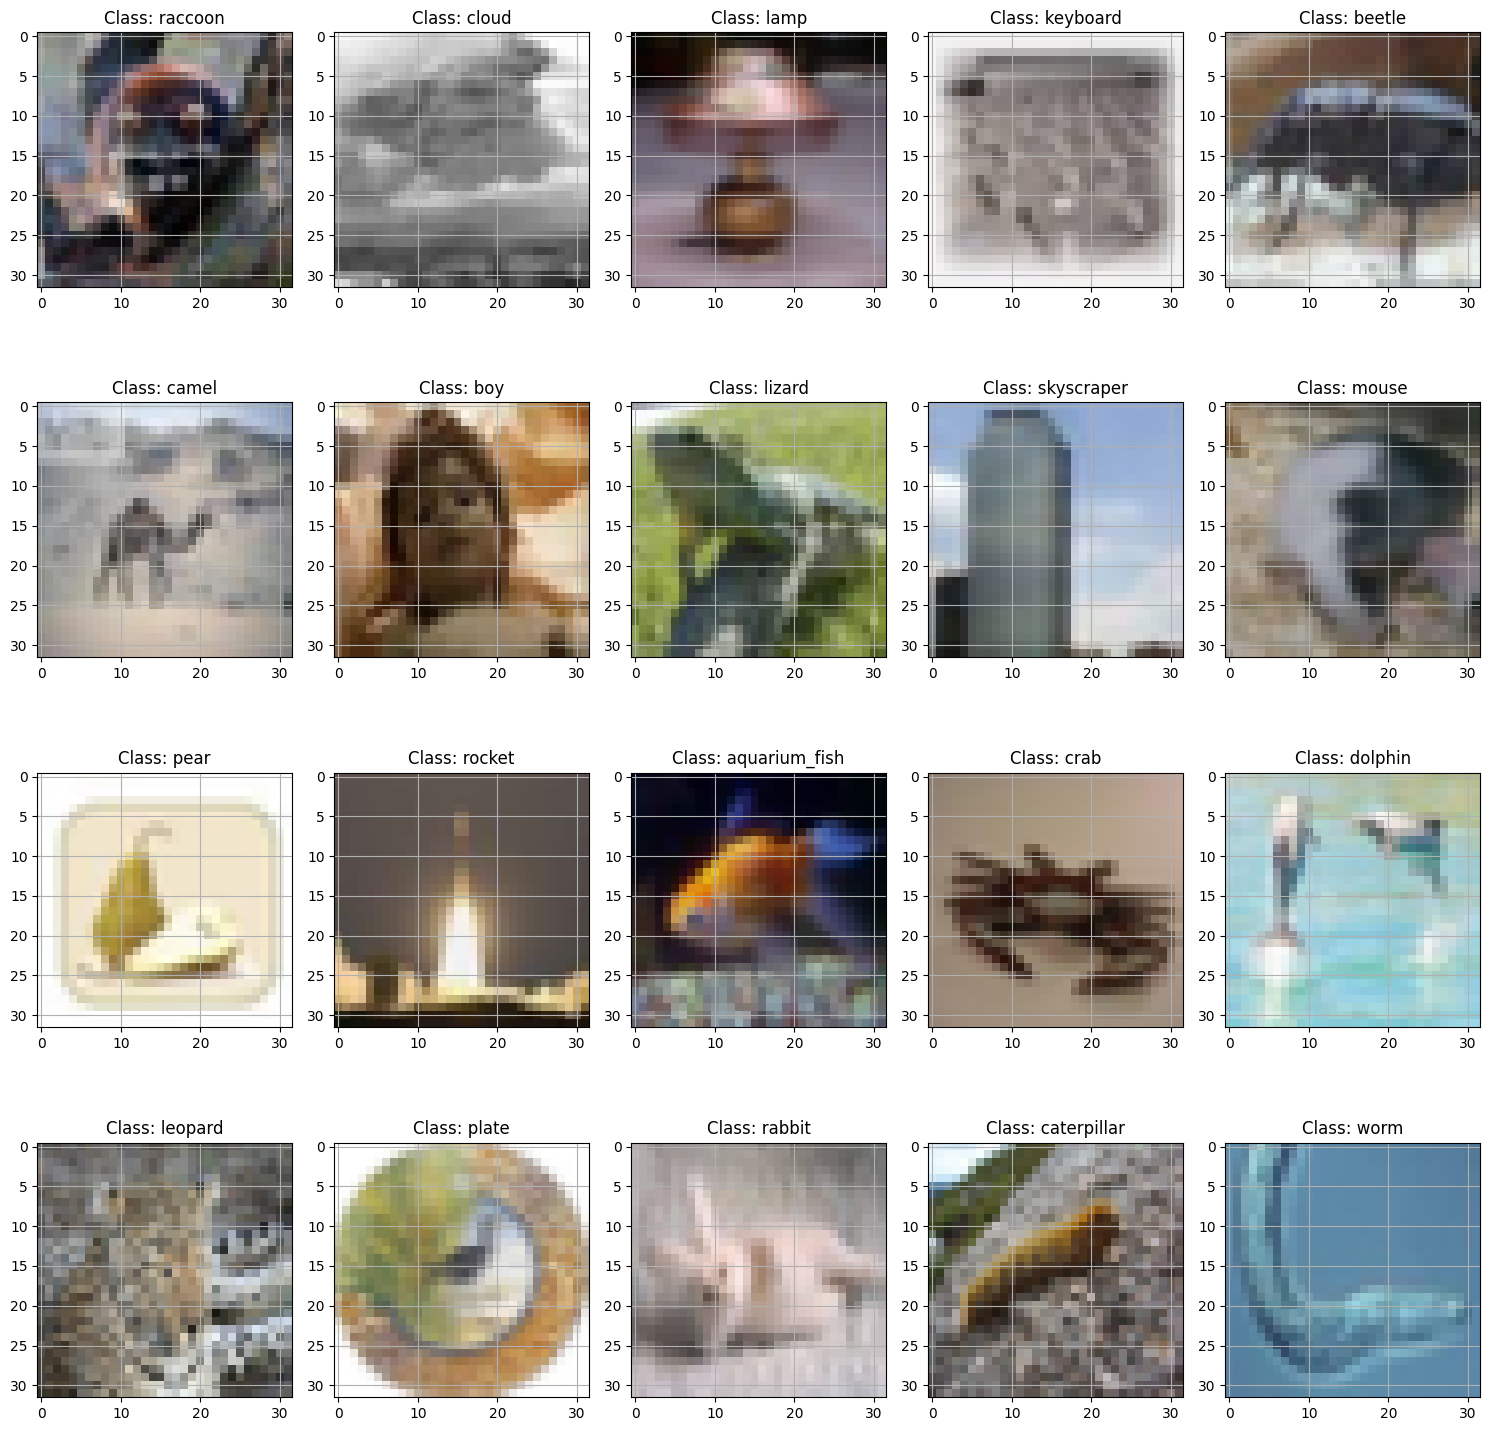

In [9]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

In [10]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [11]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

simple_bnn_no_cbam = tf.keras.models.Sequential([   #Model name

    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(100, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])


In [14]:
lq.models.summary(simple_bnn_no_cbam)

+sequential stats---------------------------------------------------------------------------------------------+
| Layer                  Input prec.            Outputs   # 1-bit  # 32-bit   Memory  1-bit MACs  32-bit MACs |
|                              (bit)                          x 1       x 1     (kB)                          |
+-------------------------------------------------------------------------------------------------------------+
| quant_conv2d                     -  (-1, 30, 30, 128)      3456         0     0.42           0      3110400 |
| batch_normalization              -  (-1, 30, 30, 128)         0       256     1.00           0            0 |
| quant_conv2d_1                   1  (-1, 30, 30, 128)    147456         0    18.00   132710400            0 |
| max_pooling2d                    -  (-1, 15, 15, 128)         0         0        0           0            0 |
| batch_normalization_1            -  (-1, 15, 15, 128)         0       256     1.00           0        

In [15]:
model=simple_bnn_no_cbam
model.compile(
    tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [16]:
history = model.fit(ds_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 57s 26ms/step - loss: 4.0549 - accuracy: 0.0829
Epoch 2/10
1563/1563 [==============================] - 40s 26ms/step - loss: 3.4924 - accuracy: 0.1752
Epoch 3/10
1563/1563 [==============================] - 40s 25ms/step - loss: 3.1232 - accuracy: 0.2537
Epoch 4/10
1563/1563 [==============================] - 40s 26ms/step - loss: 2.8210 - accuracy: 0.3250
Epoch 5/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.5828 - accuracy: 0.3833
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.3970 - accuracy: 0.4351
Epoch 7/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.2373 - accuracy: 0.4777
Epoch 8/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.1219 - accuracy: 0.5126
Epoch 9/10
1563/1563 [==============================] - 40s 25ms/step - loss: 2.0054 - accuracy: 0.5490
Epoch 10/10
1563/1563 [==============================] - 39s 25m

In [17]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

simple_bnn_with_cbam = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    cbam(tf.keras.layers.Input(shape=ds_info.features['image'].shape)),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 256))),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 256))),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 512))),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 512))),

    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(100, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

In [18]:
modeel=simple_bnn_with_cbam
modeel.compile(
    tf.keras.optimizers.legacy.Adam(learning_rate=0.01, decay=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [19]:
history = modeel.fit(ds_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 41s 25ms/step - loss: 4.0462 - accuracy: 0.0872
Epoch 2/10
1563/1563 [==============================] - 39s 25ms/step - loss: 3.4708 - accuracy: 0.1792
Epoch 3/10
1563/1563 [==============================] - 39s 25ms/step - loss: 3.0938 - accuracy: 0.2585
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.7858 - accuracy: 0.3310
Epoch 5/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.5488 - accuracy: 0.3933
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.3741 - accuracy: 0.4367
Epoch 7/10
1563/1563 [==============================] - 40s 25ms/step - loss: 2.2270 - accuracy: 0.4808
Epoch 8/10
1563/1563 [==============================] - 39s 25ms/step - loss: 2.1007 - accuracy: 0.5216
Epoch 9/10
1563/1563 [==============================] - 39s 25ms/step - loss: 1.9924 - accuracy: 0.5543
Epoch 10/10
1563/1563 [==============================] - 39s 25m

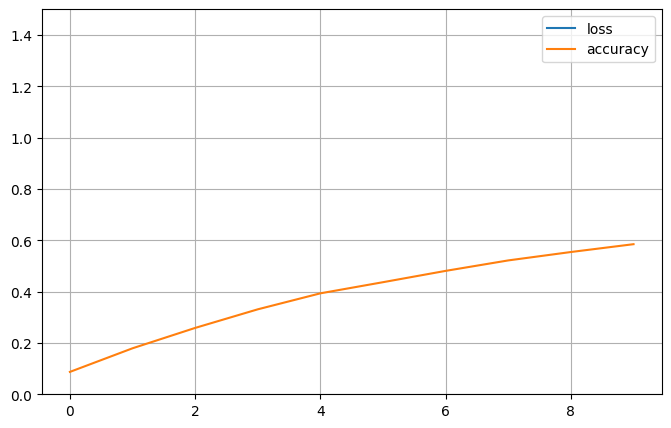

In [20]:
plotHistory(history)

In [21]:
print(f"Test accuracy: {modeel.evaluate(ds_test)[1]}")

313/313 [==============================] - 4s 11ms/step - loss: 2.5072 - accuracy: 0.4202
Test accuracy: 0.420199990272522


In [22]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00


In [23]:
from tf_explain.core.grad_cam import GradCAM

In [24]:
explainer = GradCAM()

In [25]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [26]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


1/1 [==============================] - 0s 29ms/step


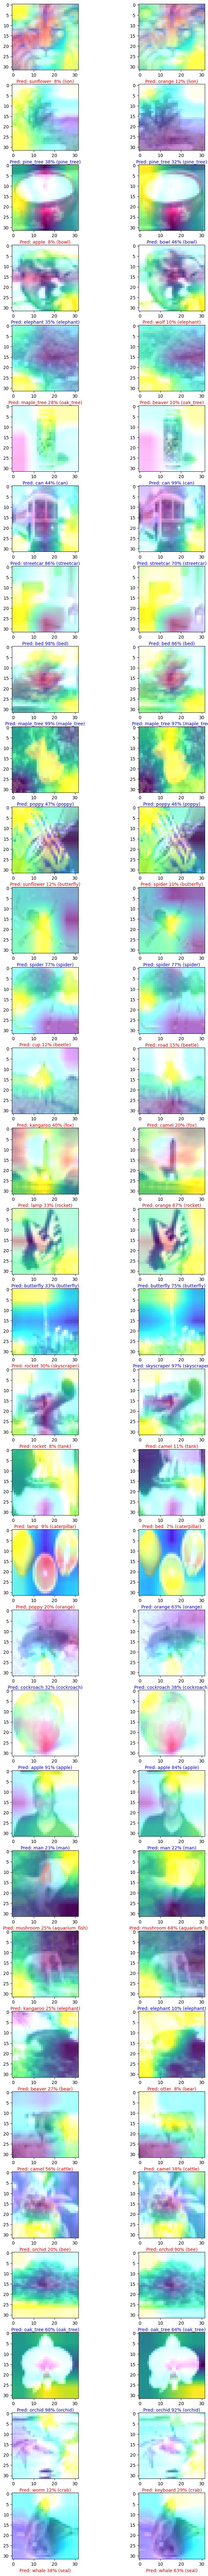

In [27]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               model,
               model.predict(img[None]),
               modeel,
               modeel.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1